In [1]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from utils.data_loader import load_price_data
from envs.bess_env import BatteryEnv

csv_path = "../data/raw/dayahead_2024_11.csv"

df, price_series, timestamps = load_price_data(
    csv_path,
    resolution="1h"   # or "15min" for finer simulation
)

## Plot Function

In [2]:
def plot_trajectory(history, title="Battery model transitions"):
    """Plot SoC, SoH and cumulative EFC over time."""

    t = np.arange(len(history["soc"]))
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    
    # SoC plot
    axes[0].plot(t, history["soc"])
    axes[0].set_ylabel("SoC [-]")
    axes[0].grid(True)

    # SoH plot
    axes[1].plot(t, history["soh"])
    axes[1].set_ylabel("SoH [-]")
    axes[1].grid(True)

    # EFC plot
    axes[2].plot(t, history["efc_cum"])
    axes[2].set_ylabel("EFC cumulative [-]")
    axes[2].set_xlabel("t [steps]")
    axes[2].grid(True)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


## Scenario 1 — Continuous Discharging  
This scenario applies maximum discharging power at each step.  
Expected behaviour:
- SoC drops to the minimum limit and stays fixed  
- SoH degrades **only** during the initial SoC change  
- EFC increases only during the first movement, then remains constant  

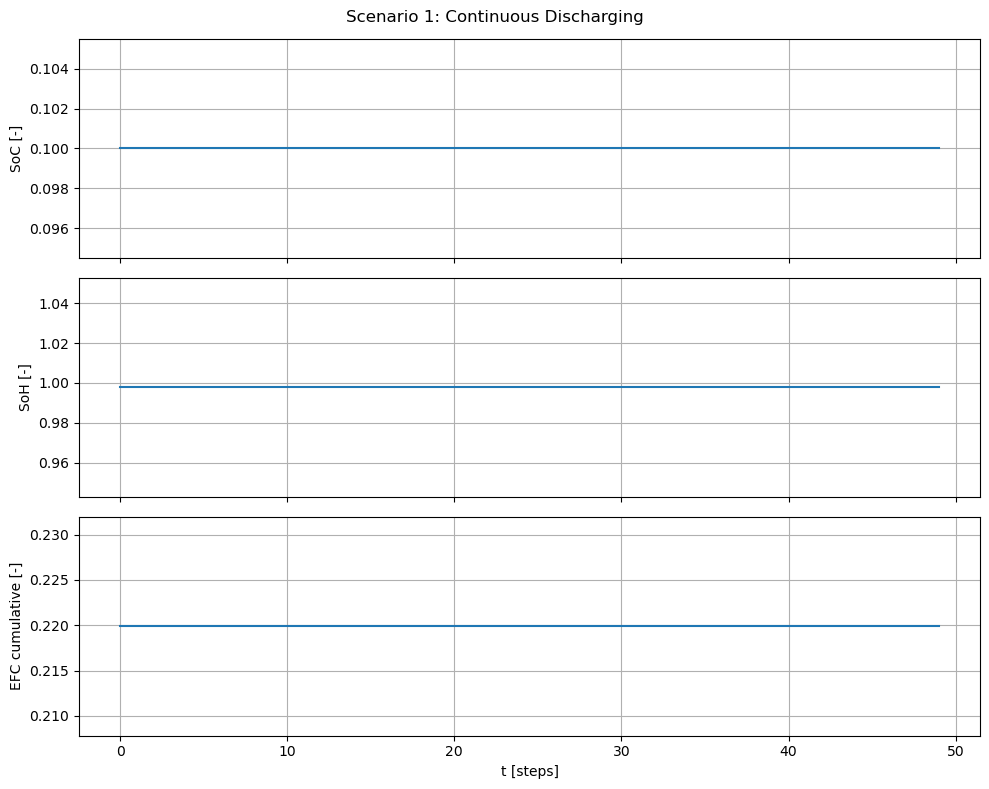

In [3]:
env = BatteryEnv(price_series=price_series,
                 dt_hours=1.0,
                 capacity_kWh=100.0,
                 p_max_kW=50.0,
                 soh_deg_per_EFC=0.01)

obs, info = env.reset()

# History buffers
history = {"soc": [], "soh": [], "efc_cum": [], "action": []}

for t in range(50):
    # Always discharge at maximum power
    action = np.array([-env.p_max], dtype=np.float32)
    obs, reward, terminated, truncated, info = env.step(action)

    # Store data
    history["soc"].append(env.soc)
    history["soh"].append(env.soh)
    history["efc_cum"].append(env._efc_acc)
    history["action"].append(action[0])

    if terminated or truncated:
        print(f"Episode terminated at t={t}")
        break

plot_trajectory(history, "Scenario 1: Continuous Discharging")

## Scenario 2 — Alternating Charging and Discharging  
This scenario applies charge/discharge power in alternating steps.  
Expected behaviour:
- SoC oscillates between the limits  
- EFC increases continuously  
- SoH decreases gradually over many steps  

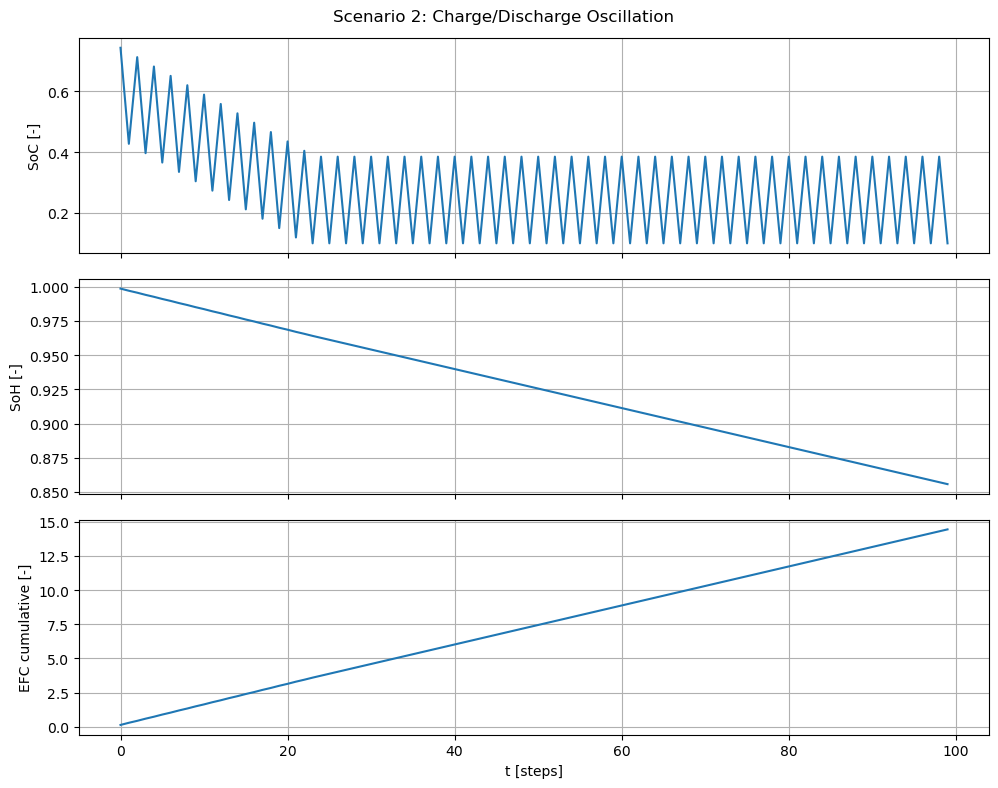

In [4]:
env = BatteryEnv(price_series=price_series,
                 dt_hours=1.0,
                 capacity_kWh=100.0,
                 p_max_kW=30.0,
                 soh_deg_per_EFC=0.01)

obs, info = env.reset()

history = {k: [] for k in ["soc", "soh", "efc_cum", "action"]}

for t in range(100):
    # Even steps: charge; odd steps: discharge
    if t % 2 == 0:
        a = +env.p_max
    else:
        a = -env.p_max

    action = np.array([a], dtype=np.float32)
    obs, reward, terminated, truncated, info = env.step(action)

    history["soc"].append(env.soc)
    history["soh"].append(env.soh)
    history["efc_cum"].append(env._efc_acc)
    history["action"].append(a)

    if terminated or truncated:
        print(f"Episode terminated at t={t}")
        break

plot_trajectory(history, "Scenario 2: Charge/Discharge Oscillation")


## Scenario 3 — SAC Agent with Real Day-Ahead Prices

In this scenario, we:
1. Load real day-ahead price data.
2. Create the `BatteryEnv` environment.
3. Train a SAC agent on the environment.
4. Run one evaluation rollout with the trained policy.
5. Plot time series of:
   - Price
   - Action (battery power)
   - State of Charge (SoC)
   - State of Health (SoH)
   - Cumulative Equivalent Full Cycles (EFC)
   - Reward per step

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 49,999/50,000  [ 0:22:05 < 0:00:01 , 37 it/s ]

Training completed.
Episode finished at t = 719
Rollout length: 720


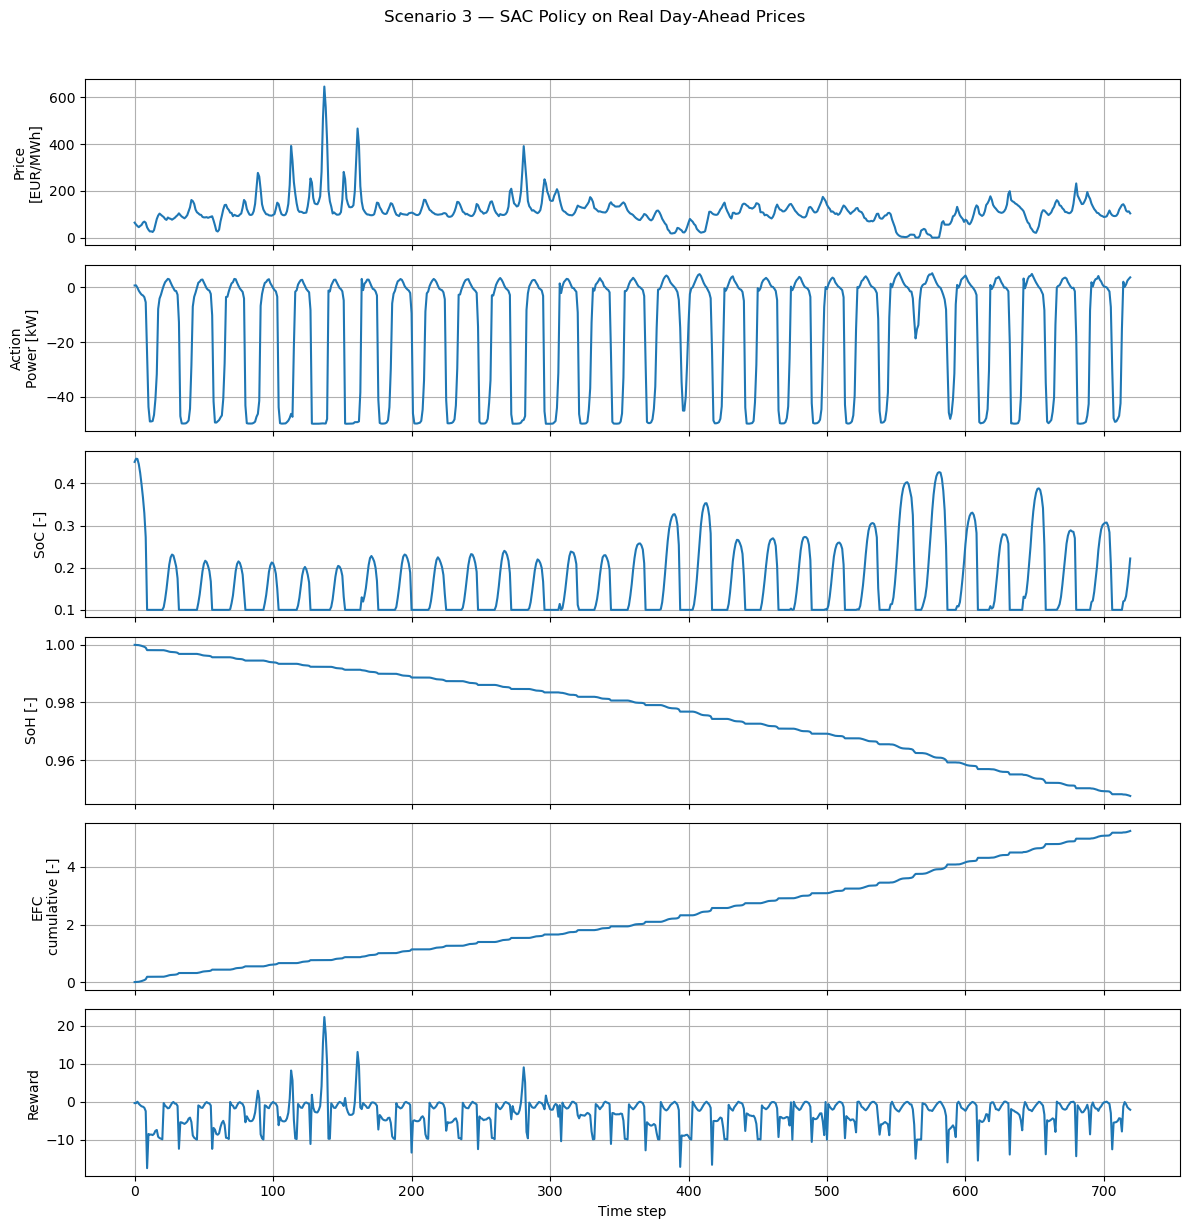

In [7]:
env = BatteryEnv(price_series=price_series,
                 dt_hours=1.0,
                 capacity_kWh=100.0,
                 p_max_kW=50.0,
                 soh_deg_per_EFC=0.01)

obs, info = env.reset()

# Create SAC agent
model = SAC(
    policy="MlpPolicy",
    env=env,
    verbose=1,
)

# Train the agent (adjust timesteps as needed)
total_timesteps = 50_000  # start small for testing, increase later
model.learn(
    total_timesteps=total_timesteps,
    log_interval=10,
    progress_bar=True,
)

print("Training completed.")

# Create a fresh environment for evaluation (same data, new episode)
eval_env = BatteryEnv(
    price_series=price_series,
    timestamps=timestamps,
    dt_hours=1.0,
    capacity_kWh=100.0,
    p_max_kW=50.0,
    soh_deg_per_EFC=0.01,
    use_simple_cycle_count=True,
    random_seed=123,  # different seed for evaluation
)

obs, info = eval_env.reset()

history = {
    "price": [],
    "action": [],
    "soc": [],
    "soh": [],
    "efc_cum": [],
    "reward": [],
}

for t in range(len(price_series)):
    # Get action from trained SAC policy
    action, _ = model.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = eval_env.step(action)

    # Store trajectories
    history["price"].append(info["price_true"])
    history["action"].append(float(action[0]))
    history["soc"].append(eval_env.soc)
    history["soh"].append(eval_env.soh)
    history["efc_cum"].append(eval_env._efc_acc)
    history["reward"].append(reward)

    if terminated or truncated:
        print(f"Episode finished at t = {t}")
        break

print("Rollout length:", len(history["soc"]))

t = np.arange(len(history["soc"]))

fig, axes = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# 1) Price
axes[0].plot(t, history["price"])
axes[0].set_ylabel("Price\n[EUR/MWh]")
axes[0].grid(True)

# 2) Action (battery power)
axes[1].plot(t, history["action"])
axes[1].set_ylabel("Action\nPower [kW]")
axes[1].grid(True)

# 3) State of Charge
axes[2].plot(t, history["soc"])
axes[2].set_ylabel("SoC [-]")
axes[2].grid(True)

# 4) State of Health
axes[3].plot(t, history["soh"])
axes[3].set_ylabel("SoH [-]")
axes[3].grid(True)

# 5) Cumulative EFC
axes[4].plot(t, history["efc_cum"])
axes[4].set_ylabel("EFC\ncumulative [-]")
axes[4].grid(True)

# 6) Reward per step
axes[5].plot(t, history["reward"])
axes[5].set_ylabel("Reward")
axes[5].set_xlabel("Time step")
axes[5].grid(True)

fig.suptitle("Scenario 3 — SAC Policy on Real Day-Ahead Prices", y=1.02)
plt.tight_layout()
plt.show()

## Consistency Check — Does the SoH Degradation Match EFC?
This calculation verifies that the SoH reduction follows the model:
  
\[
\Delta SoH = \text{soh\_deg\_per\_EFC} \times \text{EFC\_cum}
\]

In [5]:
print("Final SoH:", env.soh)
print("Final cumulative EFC:", env._efc_acc)
print("soh_deg_per_EFC:", env.soh_deg_per_EFC)

soh_theoretical = 1.0 - env.soh_deg_per_EFC * env._efc_acc
print("Theoretical SoH (approx):", soh_theoretical)

Final SoH: 0.8557100727007675
Final cumulative EFC: 14.428992729923216
soh_deg_per_EFC: 0.01
Theoretical SoH (approx): 0.8557100727007678
